# Facial Age Group Estimation Model

Our Facial Age Group Estimation Model is crafted to predict individuals' age groups based on facial images.

This model employs transfer learning and fine-tuning techniques in the construction of a Convolutional Neural Network (CNN) for accurate face age group estimation.

#### The model was developed through the following steps

#### Step 1 - Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

2023-11-23 00:04:19.161614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Step 2 -  Data Directory and Configuration

In [2]:
# Define the paths to the train, test, and validation data
train_path = 'Faces_images/train'
test_path = 'Faces_images/test'
valid_path = 'Faces_images/validation'

# Get a list of folders in the train_path and sort them 
folders = sorted(glob(os.path.join(train_path, '*')), key=lambda x: int(os.path.basename(x).split('-')[0]) if '-' in os.path.basename(x) else int(os.path.basename(x).split('+')[0]))

# Define the image size and Batch size
IMAGE_SIZE = [224, 224]
batch_size = 32

# Define the class labels
class_labels = ['0-3', '4+', '9+', '12+', '17+']

#### Step 3 Image Data Augmentation, Normalization and Loading for Training, Validation, and Test Sets







In [4]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom transformation
    horizontal_flip=True  # Horizontal flip
)

# Data normalization for Validation Set 
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data normalization for Test Set 
test_datagen = ImageDataGenerator(rescale=1./255)


# Data Generators for loading data into batches
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

validation_set = validation_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',# Uses one-hot encoding
    classes=class_labels
)

Found 13618 images belonging to 5 classes.
Found 1703 images belonging to 5 classes.
Found 1706 images belonging to 5 classes.


#### Step 4 - Building the CNN Model with pre-trained VGG16 model and compiling it and Using Early Stopping and Learning Rate Schedule 


In [5]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for training 
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model 
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Early Stopping and Learning Rate Schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Step 5 - Training the Model


In [6]:
# Fine-tune the model
history = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    validation_data=validation_set,
    validation_steps=len(validation_set),
    epochs=40,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40


2023-11-23 00:04:38.138355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - ETA: 0s - loss: 1.9213 - accuracy: 0.5224

2023-11-23 00:46:15.634628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


426/426 [==============================] - 2862s 7s/step - loss: 1.9213 - accuracy: 0.5224 - val_loss: 1.4138 - val_accuracy: 0.5672 - lr: 0.0010
Epoch 2/40
426/426 [==============================] - 3331s 8s/step - loss: 1.3477 - accuracy: 0.5767 - val_loss: 1.5276 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 3/40
426/426 [==============================] - 3099s 7s/step - loss: 1.3022 - accuracy: 0.5767 - val_loss: 1.3734 - val_accuracy: 0.5655 - lr: 0.0010
Epoch 4/40
426/426 [==============================] - 3018s 7s/step - loss: 1.3071 - accuracy: 0.5706 - val_loss: 1.2459 - val_accuracy: 0.5749 - lr: 0.0010
Epoch 5/40
426/426 [==============================] - 3029s 7s/step - loss: 1.3157 - accuracy: 0.5707 - val_loss: 1.7556 - val_accuracy: 0.4216 - lr: 0.0010
Epoch 6/40
426/426 [==============================] - 3106s 7s/step - loss: 1.3156 - accuracy: 0.5634 - val_loss: 1.3910 - val_accuracy: 0.5173 - lr: 0.0010
Epoch 7/40
426/426 [==============================] - 3028s 7s/step -

#### Step 6 - Evaluating the Model

In [7]:
# Evaluate the Model on the Test Set
test_loss, test_acc = model.evaluate(test_set, steps=len(test_set))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

2023-11-23 18:18:26.026644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


54/54 [==============================] - 194s 4s/step - loss: 0.8025 - accuracy: 0.7040
Test Loss: 0.8024563789367676
Test Accuracy: 0.7039859294891357


##### Confusion Matrix Visualization and Model Performance Report


1/1 [==============================] - 1s 1s/step


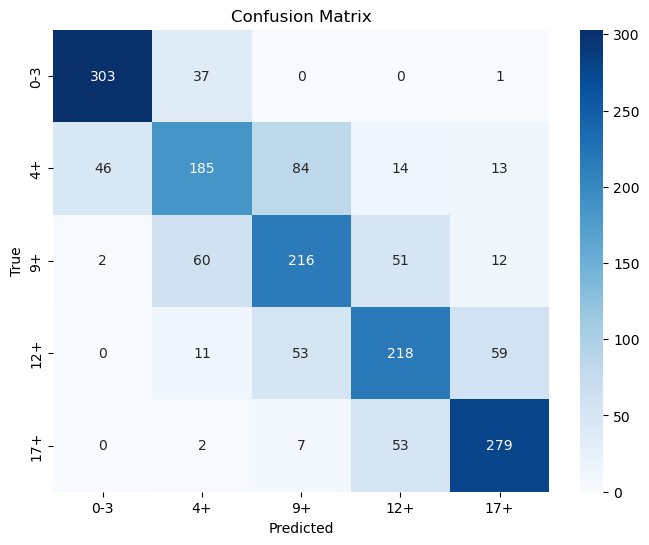

              precision    recall  f1-score   support

         0-3       0.86      0.89      0.88       341
          4+       0.63      0.54      0.58       342
          9+       0.60      0.63      0.62       341
         12+       0.65      0.64      0.64       341
         17+       0.77      0.82      0.79       341

    accuracy                           0.70      1706
   macro avg       0.70      0.70      0.70      1706
weighted avg       0.70      0.70      0.70      1706



In [8]:
# Initialize variables to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test set and make predictions
for i in range(len(test_set)):
    images, labels = test_set[i]
    true_labels.extend(np.argmax(labels, axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

#### Step 7 - Plotting Loss and Accuracy Curves

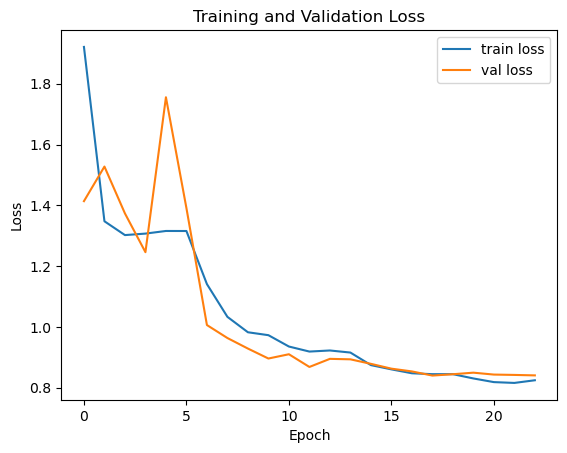

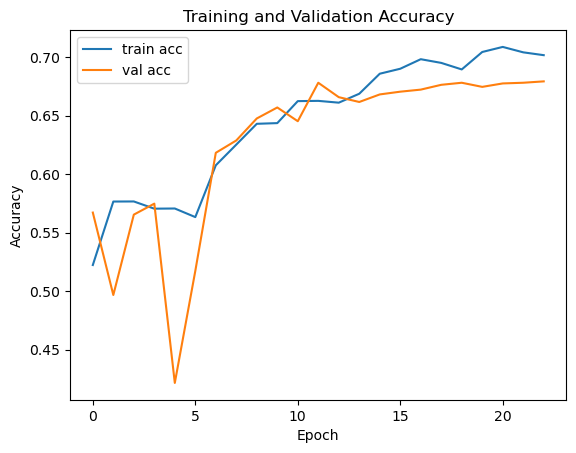

In [9]:
# Plotting Loss Curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plotting Accuracy Curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

#### Step 8 and the last one- Saving the Model

In [10]:
# Saving the Model if needed to use
model.save('AgeGroupEstimation_FineTuneModel.h5')

#### Results: The model halts training through the early stopping technique due to a lack of improvement, resulting in an accuracy of approximately 70% on the test data. While this falls short of being our best result.